In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pickle
import yaml
from tqdm import tqdm

import sys
sys.path.append("../")
from models import DiscreteNAM, NAM
from utils import discretize, get_dataset, get_bin_counts, get_discetized_run_data_survival, get_run_data, get_ebm_run_data

sys.path.append("../run_scripts")
from epoch_functions import train_epoch_nam_pairs, test_epoch_nam_pairs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_shape_fn_discrete_nam_(col, dataset, seed, split, pred_time, use_feature_set=True):
    
    # Read in model
    model = torch.load(f"../model_saves/discrete_nam_survival_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_survival_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data_survival(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=use_feature_set)
    
    if use_feature_set:
        selected_feats = data_dict["selected_feats"]  
        X_train_discrete = data_dict["X_train_discrete"].iloc[:, selected_feats]
    else:
        X_train_discrete = data_dict["X_train_discrete"]
    
    n_bins = data_dict["n_bins"]
    feature_bins = data_dict["feature_bins"]
        
    bin_counts = [
        get_bin_counts(X_train_discrete[col], nb) for col, nb in zip(X_train_discrete.columns, n_bins)
    ]

    # Compute intercept to center the shape functions
    model.compute_intercept(bin_counts)

    col_index = X_train_discrete.columns.get_loc(col)

    feat_bin_scores = model.get_bin_scores(feat_index=col_index, center=True).cpu().numpy()
    
    eval_times = data_dict["eval_times"]
    pred_time_index = np.searchsorted(eval_times, pred_time, side="right") - 1
    feat_bin_scores = feat_bin_scores[:, pred_time_index]

    # 1: to remove the missing bin
    feat_bin_scores = feat_bin_scores[1:]

    # Prepend the minimum value of the feature for plotting purposes
    feat_bin_values = np.concatenate([
        [feature_bins[col_index].min() - 0.01],
        feature_bins[col_index]
    ])
    
    return model, feat_bin_values, feat_bin_scores

In [3]:
def get_shape_fn_discrete_nam(col, dataset, seed, pred_time, use_feature_set=True):
    
    splits = [1, 2, 3, 4, 5]
    
    results = []
    for split in splits:
        _, feat_bin_values, feat_bin_scores = get_shape_fn_discrete_nam_(
            col, dataset, seed, split, pred_time, use_feature_set=use_feature_set
        )
        results.append(
            pd.DataFrame({
                "feature_value": feat_bin_values,
                "feature_score": feat_bin_scores,
                "pred_time": pred_time,
                "split": split
            })
        )
        
    return pd.concat(results)

In [21]:
def get_shape_fn_ebm(col, dataset, seed, use_feature_set=False):
    
    # Read in model
    with open(f"../model_saves/ebm_{dataset}_seed{seed}.pkl", "rb") as f:
        ebm = pickle.load(f)
        
    data_dict = get_ebm_run_data(dataset, seed)
    X_train = data_dict["X_train"]
    
    if use_feature_set:
        # Save selected_features to yaml
        with open(f"../feature_sets/coxnet_{dataset}_seed{seed}.yaml", "r") as f:
            selected_features = yaml.safe_load(f)
        
        X_train = X_train[selected_features]
    
    feat_idx = ebm.feature_names_in_.index(col)

    ebm_global = ebm.explain_global()
    
    shape_data = ebm_global.data(feat_idx)
    
    return shape_data

In [24]:
dnam_data_short_term = get_shape_fn_discrete_nam("max:3004501_8840", "heart_failure_survival", 10, 365*1, use_feature_set=True)

Number of categorical features 3
Number of categorical features 3
Number of categorical features 3
Number of categorical features 3
Number of categorical features 3


In [18]:
dnam_data = get_shape_fn_discrete_nam("max:3004501_8840", "heart_failure_survival", 10, 365*5, use_feature_set=True)

Number of categorical features 3
Number of categorical features 3
Number of categorical features 3
Number of categorical features 3
Number of categorical features 3


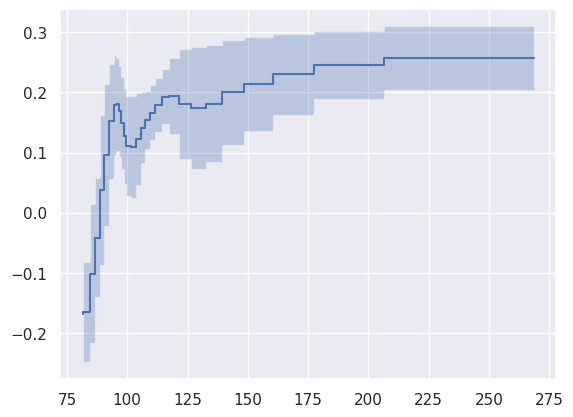

In [25]:
dnam_groupby = dnam_data_short_term.groupby("feature_value")["feature_score"]
plt.plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
plt.fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

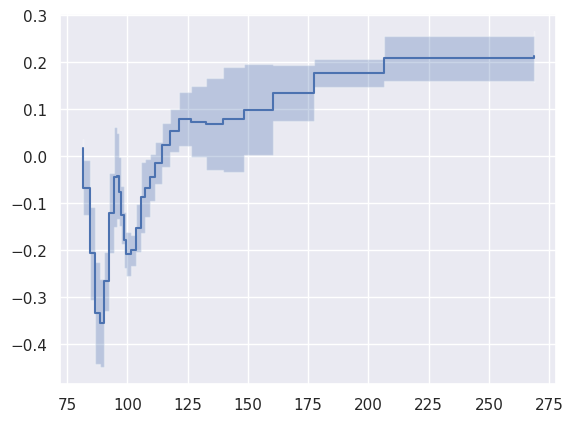

In [19]:
dnam_groupby = dnam_data.groupby("feature_value")["feature_score"]
plt.plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
plt.fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

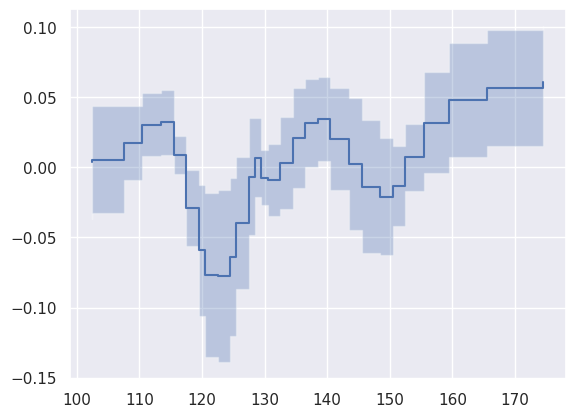

In [18]:
dnam_groupby = dnam_data.groupby("feature_value")["feature_score"]
plt.plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
plt.fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)

In [11]:
_, feat_bin_values, feat_bin_scores = get_shape_fn_discrete_nam_(
    "age", "heart_failure_survival", seed=10, split=1, pred_time=365*3, use_feature_set=True
)

In [22]:
col = "max:3004501_8840"
dataset = "heart_failure_survival"
seed = 10

ebm_shape_data = get_shape_fn_ebm(col, dataset, seed)

In [28]:
dataset = "heart_failure_survival"
split = 1
seed = 10

data_dict = \
    get_discetized_run_data_survival(
        dataset, seed=seed, split=split, max_bins=32, use_feature_set=True
    )

Number of categorical features 3


In [35]:
data_dict["X_train_discrete"].columns.get_loc("max:3004501_8840")

2519

<Axes: >

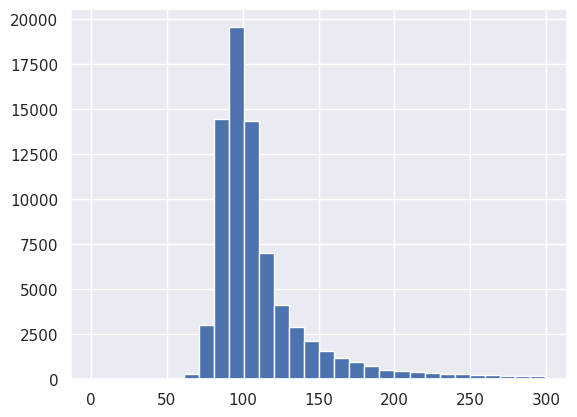

In [45]:
data_dict["X_train"].loc[data_dict["X_train"]["max:3004501_8840"] < 300, "max:3004501_8840"].hist(bins=30)

<Axes: >

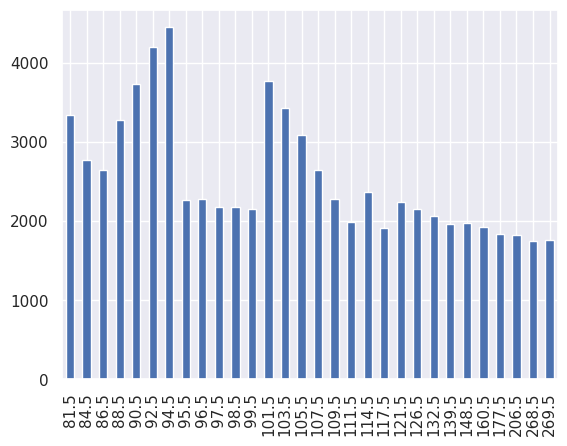

In [40]:
glucose_counts = get_bin_counts(
    data_dict["X_train_discrete"]["max:3004501_8840"], 
    data_dict["n_bins"][data_dict["X_train_discrete"].iloc[:, data_dict["selected_feats"]].columns.get_loc("max:3004501_8840")]
)

glucose_bins = data_dict["feature_bins"][data_dict["X_train_discrete"].iloc[:, data_dict["selected_feats"]].columns.get_loc("max:3004501_8840")]
glucose_bins = np.concatenate([glucose_bins, [glucose_bins.max() + 1]])

glucose_counts = pd.Series(glucose_counts[1:], index=glucose_bins)

glucose_counts.plot(kind="bar")

In [13]:
data_dict["X_train_discrete"].columns[data_dict["selected_feats"]]

Index(['condition_short_term_313217', 'cat_meas:3050380_0', 'smoking',
       'last_meas:3020891_586323', 'last_meas:3013682_8840',
       'last_meas:3019897_8554', 'last_meas:40764999_0',
       'last_meas:3020509_8523', 'mean:3038553_0', 'mean:3004249_0',
       'mean:3027598_8876', 'mean:4154790_8876', 'mean:3016723_8840',
       'mean:3027114_8840', 'mean:3029187_8845', 'std:3036277_9330',
       'std:4152194_8876', 'min:3025315_9373', 'min:3012888_0',
       'min:46236952_710208', 'min:3011163_8840', 'min:4331302_8840',
       'max:3020891_586323', 'max:3027598_8876', 'max:4152194_8876',
       'max:3004501_8840', 'max:3016723_8840', 'max:3025809_9592', 'age'],
      dtype='object')

In [50]:
ebm_shape_data["names"]

[2.0,
 81.5,
 84.5,
 86.5,
 88.5,
 90.5,
 92.5,
 94.5,
 95.5,
 96.5,
 98.5,
 99.5,
 101.5,
 103.5,
 105.5,
 107.5,
 109.5,
 111.5,
 114.5,
 117.5,
 120.5,
 124.5,
 129.5,
 135.5,
 142.5,
 151.5,
 162.5,
 179.5,
 207.5,
 268.5,
 2500.0]

In [55]:
len(ebm_shape_data["scores"]), len(ebm_shape_data["names"])

(30, 31)

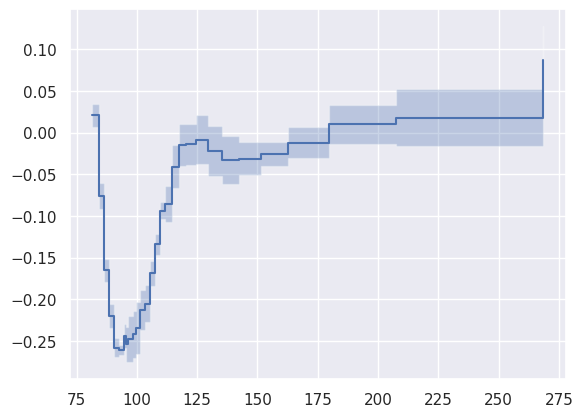

In [59]:
plt.plot(ebm_shape_data["names"][1:-1], ebm_shape_data["scores"][:-1], drawstyle='steps-post')
plt.fill_between(
    ebm_shape_data["names"][1:-1],
    ebm_shape_data["lower_bounds"][:-1],
    ebm_shape_data["upper_bounds"][:-1],
    alpha=0.3,
    step='post'
)

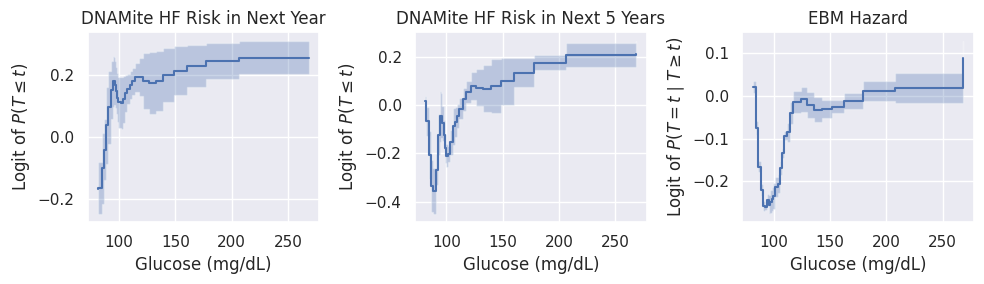

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

dnam_groupby = dnam_data_short_term.groupby("feature_value")["feature_score"]
axes[0].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[0].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[0].set_title("DNAMite HF Risk in Next Year")
axes[0].set_xlabel("Glucose (mg/dL)")
axes[0].set_ylabel(r"Logit of $P(T \leq t)$")

dnam_groupby = dnam_data.groupby("feature_value")["feature_score"]
axes[1].plot(dnam_groupby.mean().index, dnam_groupby.mean(), drawstyle='steps-post')
axes[1].fill_between(
    dnam_groupby.mean().index,
    dnam_groupby.mean() - 1.96 * dnam_groupby.sem(),
    dnam_groupby.mean() + 1.96 * dnam_groupby.sem(),
    alpha=0.3,
    step='post'
)
axes[1].set_title("DNAMite HF Risk in Next 5 Years")
axes[1].set_xlabel("Glucose (mg/dL)")
axes[1].set_ylabel(r"Logit of $P(T \leq t)$")

axes[2].plot(ebm_shape_data["names"][1:-1], ebm_shape_data["scores"][:-1], drawstyle='steps-post')
axes[2].fill_between(
    ebm_shape_data["names"][1:-1],
    ebm_shape_data["lower_bounds"][:-1],
    ebm_shape_data["upper_bounds"][:-1],
    alpha=0.3,
    step='post'
)
axes[2].set_title("EBM Hazard")
axes[2].set_xlabel("Glucose (mg/dL)")
axes[2].set_ylabel(r"Logit of $P(T = t \mid T \geq t)$")

plt.tight_layout()
plt.savefig("figures/hf_shape_fns.pdf")

In [12]:
def get_importances_discrete_nam_(dataset, seed, split, pred_time, use_feature_set=True):
    
    # Read in model
    model = torch.load(f"../model_saves/discrete_nam_survival_{dataset}_seed{seed}_split{split}.pt")
    
    # Read in args using yaml
    args_id = model.params_id
    with open(f"../run_parameters/discrete_nam_survival_{dataset}_seed{seed}_split{split}_params{args_id}.yaml", "r") as f:
        args = yaml.safe_load(f)
    
    
    data_dict = \
        get_discetized_run_data_survival(dataset, seed=seed, split=split, max_bins=args["max_bins"], use_feature_set=use_feature_set)
    
    if use_feature_set:
        selected_feats = data_dict["selected_feats"]  
        X_train_discrete = data_dict["X_train_discrete"].iloc[:, selected_feats]
    else:
        X_train_discrete = data_dict["X_train_discrete"]
    
    n_bins = data_dict["n_bins"]
    feature_bins = data_dict["feature_bins"]
        
    bin_counts = [
        get_bin_counts(X_train_discrete[col], nb) for col, nb in zip(X_train_discrete.columns, n_bins)
    ]
    
    eval_times = data_dict["eval_times"]
    pred_time_index = np.searchsorted(eval_times, pred_time, side="right") - 1

    # Compute intercept to center the shape functions
    model.compute_intercept(bin_counts)
    
    importances = []
    for col_index in tqdm(range(X_train_discrete.shape[1])):
        feat_bin_scores = model.get_bin_scores(feat_index=col_index, center=True).cpu().numpy()
        feat_bin_scores = feat_bin_scores[:, pred_time_index]
        
        feat_importance = np.sum(
            np.abs(feat_bin_scores) * bin_counts[col_index]
        ) / np.sum(bin_counts[col_index])

        importances.append(feat_importance)
        
        
    return X_train_discrete.columns, importances

In [13]:
features, importances = get_importances_discrete_nam_("heart_failure_survival", 10, 1, 365*5, use_feature_set=True)

Number of categorical features 3


100%|██████████| 29/29 [00:00<00:00, 774.06it/s]


In [17]:
imp_df = pd.DataFrame({
    "feature": features,
    "importance": importances
})

imp_df.sort_values("importance", ascending=False)

,feature,importance
28,age,0.832584
26,max:3016723_8840,0.120872
17,min:3025315_9373,0.120758
8,mean:3038553_0,0.115758
25,max:3004501_8840,0.111683
11,mean:4154790_8876,0.104566
15,std:3036277_9330,0.097176
9,mean:3004249_0,0.093772
18,min:3012888_0,0.093712
16,std:4152194_8876,0.092422
